Import the libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization
import tensorflow as tf
from google.colab import files
import numpy as np


load the dataset 1

In [ ]:
file_path = "clickbait.csv"  # Path to your CSV file
data = pd.read_csv(file_path)

# Display the first few rows to confirm the data structure
print(data.head())

titles_one = data['title'].values
labels_one = data['label'].values

                                               title  label
0  15 Highly Important Questions About Adulthood,...      1
1  250 Nuns Just Cycled All The Way From Kathmand...      1
2  Australian comedians "could have been shot" du...      0
3  Lycos launches screensaver to increase spammer...      0
4  Fußball-Bundesliga 2008–09: Goalkeeper Butt si...      0


load the gen dataset

In [ ]:
file_path = "gen_clickbait.csv"  # Path to your CSV file
data = pd.read_csv(file_path)

# Display the first few rows to confirm the data structure
print(data.head())


gen_titles = data['title'].values
gen_labels = data['label'].values

print(len(gen_titles))
print(len(gen_labels))


                                               title  label
0  21 Things Only People Who Love Coffee Will Und...      1
1  30 Things You Didn't Know You Needed Until Rig...      1
2       12 Ways To Make Your Mornings Less Miserable      1
3  Scientists Discover New Species In The Depths ...      0
4  Local Bakery Wins National Award For Best Croi...      0
126
126


load the kaggle dataset

In [ ]:
file_path = "kaggle_clickbait_data.csv"  # Path to your CSV file
data = pd.read_csv(file_path)

# Display the first few rows to confirm the data structure
print(data.head())


kaggle_titles = data['title'].values
kaggle_labels = data['label'].values

print(len(kaggle_titles))
print(len(kaggle_labels))


                                               title  label
0                                 Should I Get Bings      1
1      Which TV Female Friend Group Do You Belong In      1
2  The New "Star Wars: The Force Awakens" Trailer...      1
3  This Vine Of New York On "Celebrity Big Brothe...      1
4  A Couple Did A Stunning Photo Shoot With Their...      1
32000
32000


Combine the three labeled datasets

In [ ]:
# Combine titles and labels of the three datasets
titles = np.concatenate((titles_one, gen_titles, kaggle_titles))
labels = np.concatenate((labels_one, gen_labels, kaggle_labels))

print(len(titles))
print(len(labels))

64112
64112


setting up tokenizer and preprocessing labelled titles

In [ ]:
vocab_size = 10000  # Maximum number of words in the vocabulary
max_len = 50  # Maximum number of words in a title (padding/truncating length)

# Initialize and fit the tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(titles)

#convert the text to sequence
sequences = tokenizer.texts_to_sequences(titles)

# pad the sequences to the same length
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

Split the dataset into training and testing
and validation


In [ ]:
# First, split into training + validation and test sets
X_trainNval, X_test, Y_trainNval, Y_test = train_test_split(padded_sequences, labels, test_size=0.3, random_state=42)

# Then, split the training + validation set into training and validation sets
X_train, X_validate, Y_train, Y_validate = train_test_split(X_trainNval, Y_trainNval, test_size=0.1, random_state=42)


print(len(X_trainNval))
print(len(X_validate))
print(len(X_train))
print(len(X_test))

# random number that is used when shuffling data.
# if this is not given it will generate a random number and use it to shuffle. but then if we do this again we'll get a different split. but if we configure once like this and also the next time
# then the same split can be acquried.

44878
4488
40390
19234


creating the CNN

In [ ]:
embedding_dim = 128  # Embedding vector size


initial_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.6),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])


Compile the model

In [ ]:
initial_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
print(len(padded_sequences))
print(len(labels))





64112
64112


Train the model

In [ ]:
history = initial_model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_validate, Y_validate))



Epoch 1/10
1263/1263 [==============================] - 17s 12ms/step - loss: 0.2208 - accuracy: 0.9534 - val_loss: 0.0460 - val_accuracy: 0.9857
Epoch 2/10
1263/1263 [==============================] - 15s 12ms/step - loss: 0.0447 - accuracy: 0.9901 - val_loss: 0.0419 - val_accuracy: 0.9886
Epoch 3/10
1263/1263 [==============================] - 15s 12ms/step - loss: 0.0301 - accuracy: 0.9927 - val_loss: 0.0508 - val_accuracy: 0.9877
Epoch 4/10
1263/1263 [==============================] - 15s 12ms/step - loss: 0.0297 - accuracy: 0.9930 - val_loss: 0.0536 - val_accuracy: 0.9862
Epoch 5/10
1263/1263 [==============================] - 15s 12ms/step - loss: 0.0276 - accuracy: 0.9932 - val_loss: 0.0602 - val_accuracy: 0.9869
Epoch 6/10
1263/1263 [==============================] - 16s 12ms/step - loss: 0.0243 - accuracy: 0.9941 - val_loss: 0.0580 - val_accuracy: 0.9873
Epoch 7/10
1263/1263 [==============================] - 15s 12ms/step - loss: 0.0254 - accuracy: 0.9936 - val_loss: 0.0641 -

Evaluate the model

In [ ]:
test_loss, test_acc = initial_model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {test_acc}")

602/602 [==============================] - 2s 3ms/step - loss: 0.0642 - accuracy: 0.9880
Test Accuracy: 0.9880419969558716


perform predictions

In [ ]:
predictions = initial_model.predict(X_test)
print(predictions[:30])  # Display the first 10 predictions

# Convert probabilities to binary predictions
threshold = 0.5
binary_predictions = (predictions >= threshold).astype(int)

print(binary_predictions[:10])  # Display the first 10 binary predictions

602/602 [==============================] - 2s 2ms/step
[[9.9434412e-01]
 [8.6390091e-06]
 [9.9869329e-01]
 [9.9960947e-01]
 [8.4469704e-08]
 [9.9995857e-01]
 [1.4103936e-05]
 [9.9995464e-01]
 [9.9990958e-01]
 [9.5120412e-10]
 [9.9970943e-01]
 [9.9998748e-01]
 [5.6274696e-10]
 [9.9991781e-01]
 [9.9990487e-01]
 [9.9969399e-01]
 [2.7558907e-11]
 [9.9966604e-01]
 [9.9997509e-01]
 [3.5452983e-09]
 [2.1027207e-09]
 [4.9629558e-05]
 [9.2578340e-01]
 [9.9992263e-01]
 [7.4818871e-07]
 [7.2508783e-12]
 [9.9998778e-01]
 [9.9998087e-01]
 [9.9976277e-01]
 [9.9899054e-01]]
[[1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]]


Read the tartgetTitles from the train.jsonl and validation.jsonl

In [ ]:
import json

# Function to read JSONL files and extract targetTitles
def extract_titles_from_jsonl(file_path):
    titles = []
    with open(file_path, 'r') as file:
        for line in file:
            data = json.loads(line)
            if 'targetTitle' in data:
                titles.append(data['targetTitle'])
    return titles

train_file_path = 'train.jsonl'
validation_file_path = 'validation.jsonl'

train_titles = extract_titles_from_jsonl(train_file_path)
validation_titles = extract_titles_from_jsonl(validation_file_path)

all_unlabelled_titles = train_titles + validation_titles


In [ ]:
print("First 10 training titles:")
for i, title in enumerate(train_titles[:10]):
    print(f"{i+1}. {title}")
print(len(train_titles))

print("First 10 validation titles:")
for i, title in enumerate(validation_titles[:10]):
    print(f"{i+1}. {title}")
print(len(validation_titles))

First 10 training titles:
1. Wes Welker Wanted Dinner With Tom Brady, But Patriots QB Had A Better Idea
2. Hole In Ozone Layer Expected To Make Full Recovery By 2070: NASA
3. Intellectual Stimulation Trumps Money For Employee Happiness, Survey Finds
4. ‘Follow your passion’ is wrong, here are 7 habits you need instead
5. Revealed: The perfect way to cook rice so that it's perfectly fluffy and NEVER sticks to the bottom of the pan 
6. Here's what happens if your Apple AirPods get lost or stolen
7. The Reason Why Gabor Kiraly Wears THOSE Trackie Bottoms
8. You’ll Never Believe What This Family Saw in the Sky Outside Their House in Finland.
9. Should I Drink Red Wine?
10. Taste test: 29 hot sauce bottles, ranked
3200
First 10 validation titles:
1. Five Nights at Freddy’s Sequel Delayed for Weird Reason
2. Why Arizona Sheriff Joe Arpaio’s fate could hang on a single word
3. Here’s how much you should be tipping your hairdresser
4. Alan Rickman & Rupert Grint On 'CBGB,' Reuniting Post-'Pott

extracting padded seuqnces of unlabelled training data and validation data


In [ ]:
# function to extract padded sequences
def extract_padded_seuqnces(titles):

  unlabelled_sequences = tokenizer.texts_to_sequences(titles)
  padded_sequences = pad_sequences(unlabelled_sequences, maxlen=max_len, padding='post', truncating='post')
  return padded_sequences


padded_unlabelled_all_sequences = extract_padded_seuqnces(all_unlabelled_titles)


generate the pseudo labels for the unlabeled data

In [ ]:
# function to generate pseudo labels for unlabelled data and process them

def generate_formatted_pseudo_labels(padded_sequences):
  pseudo_labels = initial_model.predict(padded_sequences)
  pseudo_labels = (pseudo_labels > 0.5).astype(int).flatten() # rounding off the predicted values to 1 or 0.
  return pseudo_labels

# pseudo_labels_training = generate_formatted_pseudo_labels(padded_unlabelled_training_sequences)
# pseudo_labels_validation = generate_formatted_pseudo_labels(padded_unlabelled_validation_sequences)

pseudo_labels = generate_formatted_pseudo_labels(padded_unlabelled_all_sequences)

print(pseudo_labels)

125/125 [==============================] - 0s 3ms/step
[1 0 0 ... 1 0 0]


combine the

1.   labelled and unlabelled sequences
2.   labels and pseudo labels




In [ ]:
X_combined = np.vstack((padded_sequences, padded_unlabelled_all_sequences))
y_combined = np.concatenate((labels, pseudo_labels))

Split the combined dataset


In [ ]:

# spliting data for trainingNtesting and validation
final_X_trainNval, final_X_test,  final_Y_trainNval, final_Y_test = train_test_split(X_combined, y_combined, test_size=0.3, random_state=42)

# spliting data for training and testing
final_X_train, final_X_validate,  final_Y_train, final_Y_validate = train_test_split(final_X_trainNval, final_Y_trainNval, test_size=0.15, random_state=42)



In [ ]:
print(len(final_X_trainNval))
print(len(final_X_test))
print(len(final_X_train))
print(len(final_X_validate))

47678
20434
40526
7152


Build the final model

In [ ]:
final_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

Compile the final model

In [ ]:
final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Train the final model

In [ ]:
final_model.fit(final_X_train, final_Y_train, epochs=10, batch_size=32, validation_data=(final_X_validate,final_Y_validate) )



Epoch 1/10
1267/1267 [==============================] - 15s 11ms/step - loss: 0.0749 - accuracy: 0.9733 - val_loss: 0.0540 - val_accuracy: 0.9811
Epoch 2/10
1267/1267 [==============================] - 14s 11ms/step - loss: 0.0162 - accuracy: 0.9944 - val_loss: 0.0574 - val_accuracy: 0.9839
Epoch 3/10
1267/1267 [==============================] - 14s 11ms/step - loss: 0.0055 - accuracy: 0.9981 - val_loss: 0.0766 - val_accuracy: 0.9825
Epoch 4/10
1267/1267 [==============================] - 14s 11ms/step - loss: 0.0041 - accuracy: 0.9987 - val_loss: 0.1093 - val_accuracy: 0.9811
Epoch 5/10
1267/1267 [==============================] - 14s 11ms/step - loss: 0.0029 - accuracy: 0.9990 - val_loss: 0.1073 - val_accuracy: 0.9828
Epoch 6/10
1267/1267 [==============================] - 14s 11ms/step - loss: 0.0024 - accuracy: 0.9994 - val_loss: 0.1099 - val_accuracy: 0.9814
Epoch 7/10
1267/1267 [==============================] - 14s 11ms/step - loss: 0.0027 - accuracy: 0.9990 - val_loss: 0.1357 -

Test the accuracy of the final model

In [ ]:
final_test_loss, final_test_acc = final_model.evaluate(final_X_test, final_Y_test)
print(f"Final Test Accuracy: {final_test_acc}")

639/639 [==============================] - 2s 3ms/step - loss: 0.2020 - accuracy: 0.9803
Final Test Accuracy: 0.9803268909454346


predict the test data set with the final model

In [ ]:
predictions = final_model.predict(final_X_test)
# print(predictions[:30])  # Display the first 10 predictions

# Convert probabilities to binary predictions
threshold = 0.5
binary_predictions = (predictions >= threshold).astype(int)

# print(binary_predictions[:10])

num_to_print = 10

# Print titles and predictions
print(f"{'Title':<50} {'Prediction':<20}")
print("="*70)

for title, prediction in zip(validation_titles[:num_to_print], binary_predictions[:num_to_print]):
    print(f"{title:<50} {prediction}")

639/639 [==============================] - 2s 2ms/step
Title                                              Prediction          
Five Nights at Freddy’s Sequel Delayed for Weird Reason [1]
Why Arizona Sheriff Joe Arpaio’s fate could hang on a single word [1]
Here’s how much you should be tipping your hairdresser [1]
Alan Rickman & Rupert Grint On 'CBGB,' Reuniting Post-'Potter' And Favorite Halloween Costumes [1]
Man swallowed a microSD card and you won't believe what happened next! [0]
Sprite May Be The Best Hangover Cure, Chinese Researchers Say [1]
The Anytime Snack You Won't Feel Guilty About Eating (VIDEO) [1]
You Won’t Believe This Stunning ‘Harry Potter’ Revelation About Professor McGonagall [0]
J.J. Abrams has an answer on if there will be a post-credits scene in the new 'Star Wars' [1]
Kristin Cavallari Talks 'The Hills' Being Fake     [1]


Create the confusion matrix

In [ ]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='confusion_matrix',
                          cmap =plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, cm[i, j],
          horizontalalignment="center",
          color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 9600   280]
 [  122 10432]]


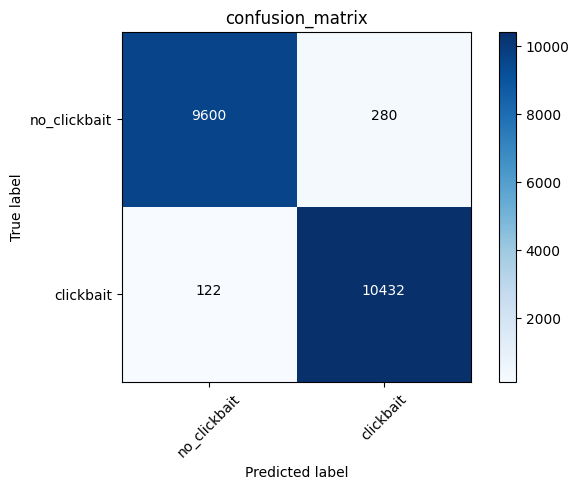

In [ ]:
cm = confusion_matrix(y_true=final_Y_test, y_pred=binary_predictions)

cm_classes = ['no_clickbait', 'clickbait']
plot_confusion_matrix(cm=cm, classes=cm_classes)

Download tokenizer

In [ ]:
tokenizer_json = tokenizer.to_json()
with open('tokenizer_v2.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

Save model

In [ ]:
# Save the model to a file (HDF5 format)
final_model.save('CNN_clickbait_model_v2.h5')

# Save the model to a directory (SavedModel format)
final_model.save('CNN_clickbait_model_v2.keras')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Download model

In [ ]:


# For TensorFlow SavedModel format
# Use the directory name instead of a file name
!zip -r CNN_clickbait_model_v1.zip CNN_clickbait_model_v1.keras
from google.colab import files

files.download('CNN_clickbait_model_v2.zip')


  adding: CNN_clickbait_model_v1.keras (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>